In [1]:
#Summarization of project steps and details

#1. Downloading data
#2. Preparing data
#3. Creating ML model
#4. Backtesting
#5. Improving accuracy of model
#6. Constant improvements - Techniques, Algorithms etc.

In [2]:
import yfinance as yf
import pandas as pd
import os
import json

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

In [3]:
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,0.055121,0.063227,0.055121,0.060524,1031788800,0.0,0.0
1986-03-14 05:00:00,0.060524,0.063767,0.060524,0.062686,308160000,0.0,0.0
1986-03-17 05:00:00,0.062686,0.064307,0.062686,0.063767,133171200,0.0,0.0
1986-03-18 05:00:00,0.063767,0.064308,0.061605,0.062145,67766400,0.0,0.0
1986-03-19 05:00:00,0.062145,0.062686,0.060524,0.061065,47894400,0.0,0.0


<Axes: >

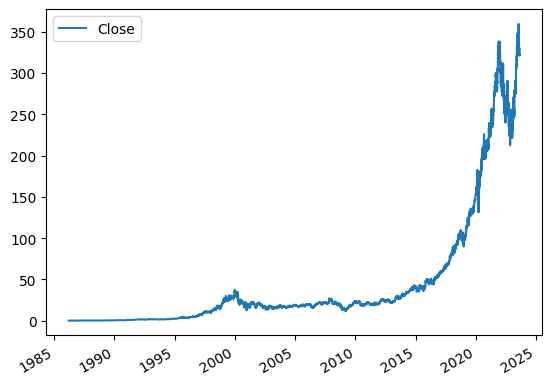

In [4]:
# Visualize MSFT stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [5]:
#Setup our data with our target, target = will the price go up or down tomorrow
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

#Using rolling to compare 2 rows at a time
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0]) ["Close"]

#Testing if our class has any imbalace
data["Target"].value_counts()

Target
1.0    4761
0.0    4670
Name: count, dtype: int64

In [6]:
data.head(5)

,Actual_Close,Target
1986-03-13 05:00:00,0.060524,NaN
1986-03-14 05:00:00,0.062686,1.0
1986-03-17 05:00:00,0.063767,1.0
1986-03-18 05:00:00,0.062145,0.0
1986-03-19 05:00:00,0.061065,0.0


In [7]:
#Set up our predictor
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [8]:
msft_prev.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 05:00:00,0.055121,0.063227,0.055121,0.060524,1.031789e+09,0.0,0.0
1986-03-17 05:00:00,0.060524,0.063767,0.060524,0.062686,3.081600e+08,0.0,0.0
1986-03-18 05:00:00,0.062686,0.064307,0.062686,0.063767,1.331712e+08,0.0,0.0
1986-03-19 05:00:00,0.063767,0.064308,0.061605,0.062145,6.776640e+07,0.0,0.0


In [9]:
# Create our training data
predictors = ["Close", "Open", "Volume", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [10]:
data.head(5)

,Actual_Close,Target,Close,Open,Volume,High,Low
1986-03-14 05:00:00,0.062686,1.0,0.060524,0.055121,1.031789e+09,0.063227,0.055121
1986-03-17 05:00:00,0.063767,1.0,0.062686,0.060524,3.081600e+08,0.063767,0.060524
1986-03-18 05:00:00,0.062145,0.0,0.063767,0.062686,1.331712e+08,0.064307,0.062686
1986-03-19 05:00:00,0.061065,0.0,0.062145,0.063767,6.776640e+07,0.064308,0.061605
1986-03-20 05:00:00,0.059444,0.0,0.061065,0.062145,4.789440e+07,0.062686,0.060524


In [11]:
#Training our Machine Learning Model

In [12]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [13]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5714285714285714

In [14]:
preds

2023-03-23 04:00:00    0.0
2023-03-24 04:00:00    0.0
2023-03-27 04:00:00    1.0
2023-03-28 04:00:00    1.0
2023-03-29 04:00:00    0.0
                      ... 
2023-08-09 04:00:00    1.0
2023-08-10 04:00:00    1.0
2023-08-11 04:00:00    0.0
2023-08-14 04:00:00    1.0
2023-08-15 04:00:00    0.0
Length: 100, dtype: float64

In [15]:
precision_score(test["Target"], preds)

0.5714285714285714

In [16]:
combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)

combined

,Target,Predictions
2023-03-23 04:00:00,1.0,0.0
2023-03-24 04:00:00,1.0,0.0
2023-03-27 04:00:00,0.0,1.0
2023-03-28 04:00:00,0.0,1.0
2023-03-29 04:00:00,1.0,0.0
...,...,...
2023-08-09 04:00:00,0.0,1.0
2023-08-10 04:00:00,1.0,1.0
2023-08-11 04:00:00,0.0,0.0
2023-08-14 04:00:00,1.0,1.0


<Axes: >

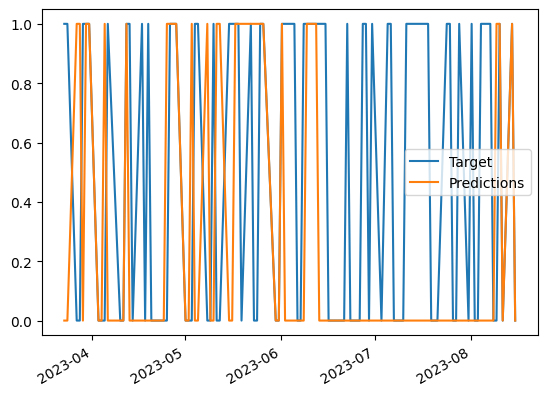

In [17]:
combined.plot()

In [18]:
#Creating backtesting for model

#1. Looping through the data
#2. Splitting the data up
#3. Train the model to predict the new few rows

In [37]:
def backtest(data, model, predictors, start=1000, step=500):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [38]:

predictions = backtest(data, model, predictors)

In [39]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

Predictions
0.0    7659
1.0     772
Name: count, dtype: int64

In [40]:

precision_score(predictions["Target"], predictions["Predictions"])

0.5207253886010362

In [41]:
#Improve on our accuracy by adding more predictors

In [42]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()

weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [43]:

data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "weekly_trend", "open_close_ratio", "high_close_ratio", "low_close_ratio"]

In [44]:
predictions = backtest(data.iloc[365:], model, full_predictors)

In [45]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5408163265306123

In [46]:
predictions["Predictions"].value_counts()

Predictions
0.0    7674
1.0     392
Name: count, dtype: int64